<h1 style="width:750px">Airbnb and the Prevalence of Ghost Hotels in London</h1>

---

| CASA0013 | Introduction to Programming for Spatial Analysts | 
|----|----|
| Programme | MSc Smart Cities and Urban Analytics |
| Bartlett | Centre for Advanced Spatial Analytics |
| Word Count | 2,500 |
| Student ID | 19140941 |
| Date | 21-01-13 |

---

## Part 1 - Reproducible Analysis

Data for this analysis was downloaded from the Inside Airbnb website at http://insideairbnb.com/get-the-data.html.

| Data Downloaded | |  | |
|----|----|----|----|
|  09 August, 2019  |  London  |  listings.csv.gz  |  Detailed Listings data for London  |
|  N/A  |  London  |  neighbourhoods.csv  |  Neighbourhood list for geo filtering  |
|  N/A  |  London  |  neighbourhoods.geojson  |  GeoJSON file of city neighbourhoods  |

**Note:** 
- With a file size of 318 MB, the original .csv file was too large for GitHub to accept. 
- The original data set contained 106 columns.
- 97 columns were removed and the remaining 9 columns were saved to a new .csv to be uploaded to GitHub.
- These steps were completed in Excel, but the python the code below could be run instead.

**Steps:**
- Load original .csv
- Create a new dataframe containing only the 9 columns needed for analysis
- Save the new datframe as a .csv file

**Code:**

In [367]:
# original = pd.read_csv('listings.csv')
# airbnb = original.loc[:, ['id', 'host_id', 'host_about', 'host_neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type']]
# airbnb.to_csv('<Path>\19-08_ab_london.csv', header=True)

- The resulting .csv file is used in the reproducible analysis below.
- The .csv file can be downloaded from GitHub at https://github.com/MattKavanaugh/I2P-Exec-Briefing. 

### Load

In [368]:
# Load libraries

import pandas as pd
import geopandas as gpd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

In [369]:
# Load dataframe

airbnb = pd.read_csv('19-08_ab_london.csv',encoding = "Latin-1")
airbnb.head()

,id,host_id,host_about,host_neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type
0,32722203,2697,"37 years old from France. Living with my wife,...",LB of Islington,Islington,51.55416,-0.10358,Apartment,Entire home/apt
1,32722192,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52603,-0.08835,Apartment,Private room
2,35913421,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52605,-0.08856,Apartment,Private room
3,32191740,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52517,-0.08842,Apartment,Private room
4,15267243,4775,Hi\r\n\r\nI expect you'd like to know somethin...,St. Luke's,Islington,51.52603,-0.08909,Apartment,Entire home/apt


#### Review

In [370]:
# Check number of rows and number of columns
# Check column names
# Check counts
# Check data types
airbnb.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85918 entries, 0 to 85917
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      85918 non-null  int64  
 1   host_id                 85918 non-null  int64  
 2   host_about              49399 non-null  object 
 3   host_neighbourhood      66720 non-null  object 
 4   neighbourhood_cleansed  85918 non-null  object 
 5   latitude                85918 non-null  float64
 6   longitude               85918 non-null  float64
 7   property_type           85918 non-null  object 
 8   room_type               85918 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.9+ MB


In [372]:
# check distribution
airbnb.describe()

,id,host_id,latitude,longitude
count,8.591800e+04,8.591800e+04,85918.000000,85918.000000
mean,2.202063e+07,8.145636e+07,51.509576,-0.127892
std,1.063342e+07,8.157314e+07,0.046265,0.092198
min,1.391300e+04,2.697000e+03,51.294790,-0.495820
25%,1.391292e+07,1.494246e+07,51.485450,-0.188020
50%,2.261328e+07,4.622586e+07,51.514040,-0.125660
75%,3.152753e+07,1.367858e+08,51.537330,-0.070000
max,3.760090e+07,2.840826e+08,51.681690,0.296570


### Clean

In [373]:
# We want to change the data type of the 'id' and 'host_id' columns from int64 to object
cols =["id", "host_id"]
airbnb[cols] = airbnb[cols].astype(object)

In [374]:
# Confirm that the data type of the 'id' and 'host_id' columns has changed to object
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85918 entries, 0 to 85917
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      85918 non-null  object 
 1   host_id                 85918 non-null  object 
 2   host_about              49399 non-null  object 
 3   host_neighbourhood      66720 non-null  object 
 4   neighbourhood_cleansed  85918 non-null  object 
 5   latitude                85918 non-null  float64
 6   longitude               85918 non-null  float64
 7   property_type           85918 non-null  object 
 8   room_type               85918 non-null  object 
dtypes: float64(2), object(7)
memory usage: 5.9+ MB


In [375]:
# Check for missing values and compare to counts
airbnb.isnull().sum()

id                            0
host_id                       0
host_about                36519
host_neighbourhood        19198
neighbourhood_cleansed        0
latitude                      0
longitude                     0
property_type                 0
room_type                     0
dtype: int64

In [376]:
# Replace missing values in 'host_about' column with "Unknown"
airbnb.host_about.fillna("Unknown")

0        37 years old from France. Living with my wife,...
1        Hi\r\n\r\nI expect you'd like to know somethin...
2        Hi\r\n\r\nI expect you'd like to know somethin...
3        Hi\r\n\r\nI expect you'd like to know somethin...
4        Hi\r\n\r\nI expect you'd like to know somethin...
                               ...                        
85913                                              Unknown
85914                                              Unknown
85915                                              Unknown
85916    Hi I'm Rosi! \nI've grown up in sunny Brasil, ...
85917                                              Unknown
Name: host_about, Length: 85918, dtype: object

In [377]:
# Replace missing values in 'host_neighbourhood' column with "Unknown"
airbnb.host_neighbourhood.fillna("Unknown")

0        LB of Islington
1             St. Luke's
2             St. Luke's
3             St. Luke's
4             St. Luke's
              ...       
85913       Canning Town
85914     LB of Haringey
85915         Grove Park
85916             Putney
85917      LB of Croydon
Name: host_neighbourhood, Length: 85918, dtype: object

### Explore

In [378]:
# Check how many unique values are there in every column?
airbnb.nunique()

id                        85918
host_id                   54438
host_about                27674
host_neighbourhood          434
neighbourhood_cleansed       33
latitude                  20732
longitude                 31996
property_type                41
room_type                     4
dtype: int64

In [379]:
# What are the 41 different property types?
airbnb['property_type'].unique()

array(['Apartment', 'Townhouse', 'Serviced apartment', 'House', 'Loft',
       'Condominium', 'Bed and breakfast', 'Cottage', 'Other',
       'Guest suite', 'Aparthotel', 'Cabin', 'Villa', 'Guesthouse',
       'Boat', 'Tiny house', 'Bungalow', 'Camper/RV', 'Hotel', 'Barn',
       'Boutique hotel', 'Hostel', 'Chalet', 'Houseboat', 'Hut', 'Yurt',
       'Parking Space', 'Nature lodge', 'Treehouse',
       'Casa particular (Cuba)', 'Plane', 'Tent', 'Earth house',
       'Lighthouse', 'Minsu (Taiwan)', 'Ryokan (Japan)', 'Island',
       'Farm stay', 'Bus', 'Campsite', 'Dome house'], dtype=object)

In [380]:
# What are the 4 different room types?
airbnb['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [381]:
# What are the 33 different neighbourhoods?
airbnb['neighbourhood_cleansed'].unique()

array(['Islington', 'Kensington and Chelsea', 'Tower Hamlets', 'Hackney',
       'Camden', 'Lambeth', 'Haringey', 'Wandsworth', 'Ealing',
       'Waltham Forest', 'Westminster', 'Southwark', 'Redbridge',
       'Enfield', 'Barnet', 'City of London', 'Hounslow', 'Newham',
       'Croydon', 'Lewisham', 'Hammersmith and Fulham', 'Merton', 'Brent',
       'Kingston upon Thames', 'Richmond upon Thames', 'Greenwich',
       'Sutton', 'Barking and Dagenham', 'Hillingdon', 'Bromley',
       'Havering', 'Harrow', 'Bexley'], dtype=object)

In [382]:
# Read in once
nbhoods = gpd.read_file('neighbourhoods.geojson')

In [383]:
nbhoods['geometry']

0     MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...
1     MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51...
2     MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...
3     MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...
4     MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...
5     MULTIPOLYGON (((0.15869 51.51219, 0.15871 51.5...
6     MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51...
7     MULTIPOLYGON (((-0.40407 51.61318, -0.40320 51...
8     MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...
9     MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...
10    MULTIPOLYGON (((-0.10580 51.69187, -0.10557 51...
11    MULTIPOLYGON (((0.01924 51.60822, 0.01931 51.6...
12    MULTIPOLYGON (((0.06937 51.54413, 0.06910 51.5...
13    MULTIPOLYGON (((-0.15657 51.32151, -0.15866 51...
14    MULTIPOLYGON (((-0.12846 51.48505, -0.12843 51...
15    MULTIPOLYGON (((-0.10892 51.50844, -0.10889 51...
16    MULTIPOLYGON (((-0.03241 51.49305, -0.03240 51...
17    MULTIPOLYGON (((-0.02485 51.48555, -0.0247

<AxesSubplot:>

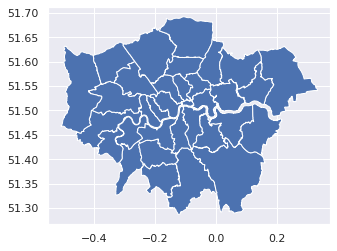

In [384]:
nbhoods.plot()

### Analyze

##### How many Airbnb listings in London are not the primary residence of the host?

In [442]:
total_listings = airbnb['id'].count()
total_hosts = airbnb['host_id'].nunique()
percent_diff_h = ((total_listings-total_hosts)/total_listings)*100
list_diff_h = total_listings-total_hosts
print(f"{total_listings} total listings were offered during August 2019.")
print(f"{total_hosts} total hosts were active during August 2019.")
print(f"There were {list_diff_h} more listings ({round(percent_diff_h)}%) than hosts during August 2019.")

85918 total listings were offered during August 2019.
54438 total hosts were active during August 2019.
There were 31480 more listings (37%) than hosts during August 2019.


In [464]:
total_eh = ((airbnb['room_type'] == 'Entire home/apt').sum())
percent_diff_eh = (total_eh/total_listings)*100
print(f"{total_eh} listings ({round(percent_diff_eh)}%) offered an entire home or apartment during August 2019.")

48253 listings (56%) offered an entire home or apartment during August 2019.


In [465]:
print(airbnb.groupby('room_type').host_id.nunique())

room_type
Entire home/apt    30212
Hotel room             6
Private room       27186
Shared room          471
Name: host_id, dtype: int64


In [471]:
# We see that there were 30212 listings where the entire home or apartment were listed with unique host ids
# Now through elimination, we can calculate home many entire homes or apartments were listed by hosts with more than one listing
multi_list_host_eh = total_eh-30212
percent_multi_list_host_eh = ((multi_list_host_eh)/total_listings)*100
print(f"{multi_list_host_eh} listings ({round(percent_multi_list_host_eh)}%) during August 2019 were for an entire home or apartment and offered by hosts with multiple listings.")

18041 listings (21%) during August 2019 were for an entire home or apartment and offered by hosts with multiple listings.


##### How many Airbnb listings in London can be attributed to hosts with multiple listings?

In [472]:
# let's do the same analysis for the remaining room types
total_pr = ((airbnb['room_type'] == 'Private room').sum())
total_hr = ((airbnb['room_type'] == 'Hotel room').sum())
total_sr = ((airbnb['room_type'] == 'Shared room').sum())
percent_diff_pr = (total_pr/total_listings)*100
percent_diff_hr = (total_hr/total_listings)*100
percent_diff_sr = (total_sr/total_listings)*100
print(f"{total_pr} listings ({round(percent_diff_pr)}%) offered a private room during August 2019.")
print(f"{total_hr} listings ({round(percent_diff_hr)}%) offered a hotel room during August 2019.")
print(f"{total_sr} listings ({round(percent_diff_sr)}%) offered a shared room during August 2019.")

36934 listings (43%) offered a private room during August 2019.
8 listings (0%) offered a hotel room during August 2019.
723 listings (1%) offered a shared room during August 2019.


In [473]:
print(airbnb.groupby('room_type').host_id.nunique())

room_type
Entire home/apt    30212
Hotel room             6
Private room       27186
Shared room          471
Name: host_id, dtype: int64


In [480]:
# From above, we see that there were:
    # 27186 listings where a private room was listed with unique host ids
    # 6 listings where a hotel room was listed with unique host ids
    # 471 listings where a shared room was listed with unique host ids
# Now through elimination, we can calculate home many private, hotel, and shared rooms were listed by hosts with more than one listing
multi_list_host_pr = total_pr-27186
multi_list_host_hr = total_hr-6
multi_list_host_sr = total_sr-471
percent_multi_list_host_pr = ((multi_list_host_pr)/total_listings)*100
percent_multi_list_host_hr = ((multi_list_host_hr)/total_listings)*100
percent_multi_list_host_sr = ((multi_list_host_sr)/total_listings)*100
print(f"{multi_list_host_pr} listings ({round(percent_multi_list_host_pr)}%) during August 2019 were for a private room and offered by hosts with multiple listings.")
print(f"{multi_list_host_hr} listings ({round(percent_multi_list_host_hr)}%) during August 2019 were for a hotel room and offered by hosts with multiple listings.")
print(f"{multi_list_host_sr} listings ({round(percent_multi_list_host_sr)}%) during August 2019 were for a shared room and offered by hosts with multiple listings.")

9748 listings (11%) during August 2019 were for a private room and offered by hosts with multiple listings.
2 listings (0%) during August 2019 were for a hotel room and offered by hosts with multiple listings.
252 listings (0%) during August 2019 were for a shared room and offered by hosts with multiple listings.


In [485]:
# How many total listings were from host with multiple listings?
print(f"A total of {multi_list_host_eh + multi_list_host_pr + multi_list_host_hr + multi_list_host_sr} listings ({round(percent_multi_list_host_eh + percent_multi_list_host_pr + percent_multi_list_host_hr + percent_multi_list_host_sr)}%) were offered by hosts with multiple listings.")

A total of 28043 listings (33%) were offered by hosts with multiple listings.


[Text(0, 0, '33889201'),
 Text(1, 0, '156158778'),
 Text(2, 0, '28820321'),
 Text(3, 0, '48165024'),
 Text(4, 0, '137094377'),
 Text(5, 0, '1432477'),
 Text(6, 0, '224866971'),
 Text(7, 0, '27572615'),
 Text(8, 0, '13557337'),
 Text(9, 0, '50291093')]

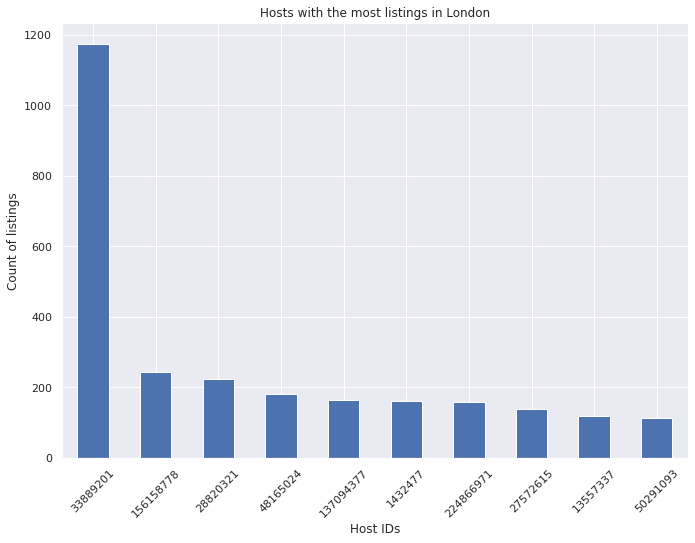

In [486]:
# What about the hosts with the most listings
top_hosts = airbnb['host_id'].value_counts().head(10)

sns.set(rc={'figure.figsize':(10,8)})

viz_bar = top_hosts.plot(kind='bar')
viz_bar.set_title('Hosts with the most listings in London')
viz_bar.set_xlabel('Host IDs')
viz_bar.set_ylabel('Count of listings')
viz_bar.set_xticklabels(viz_bar.get_xticklabels(), rotation=45)

##### How many Airbnb listings in London are operated by management companies?

In [ ]:
pip install nltk
python -m nltk.downloader all

In [153]:
#pre-processing

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string

def pre_process(corpus):
    # convert input corpus to lower case.
    corpus = corpus.lower()
    # collecting a list of stop words from nltk and punctuation form
    # string class and create single array.
    stopset = stopwords.words('english') + list(string.punctuation)
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
   corpus = " ".join([i for i in word_tokenize(corpus) if i not in stopset])
    # remove non-ascii characters
    corpus = unidecode(corpus)
    return corpus

pre_process("Sample of non ASCII: Ceñía. How to remove stopwords and punctuations?")

SyntaxError: invalid syntax (<ipython-input-153-21e8c8037306>, line 1)

In [ ]:
#Lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
words = word_tokenize(sentence)
for w in words:
    print(w, " : ", lemmatizer.lemmatize(w)

In [ ]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
# sentence pair
corpus = ["A girl is styling her hair.", "A girl is brushing her hair."]
for c in range(len(corpus)):
    corpus[c] = pre_process(corpus[c])
# creating vocabulary using uni-gram and bi-gram
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_vectorizer.fit(corpus)
feature_vectors = tfidf_vectorizer.transform(corpus)

In [ ]:
#g. Top listing words example from London – but in host_about

#Crete empty list where we are going to put the name strings
names=[]
#Getting name string from 'name' column and appending it to the empty list
for name in airbnb.name:
    names.append(name)

#Setting a function to split name strings into seperate words
def split_name(name):
    s = str(name).split()
    return s

#Create empty list where we are going to count the words
names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in split_name(n):
        word = word.lower()
        names_count.append(word)

        
from collections import Counter
top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

word_count_data = pd.DataFrame(top_25)
word_count_data.rename(columns={0:'Words',1:'Counts'},inplace=True)
viz_count = sns.barplot(x='Words',y='Counts', data = word_count_data)
viz_count.set_title('Top 25 used words for listing names')
viz_count.set_ylabel('Count of words')
viz_count.set_xlabel('Words')
viz_count.set_xticklabels(viz_count.get_xticklabels(),rotation = 90)

##### Is the problem of 'ghost hotels' concentrated in certain areas of London or spread throughout?

In [162]:
top_nbhoods = airbnb['neighbourhood_cleansed'].value_counts().head(10)
print(top_nbhoods)

Westminster               9757
Tower Hamlets             8299
Hackney                   6244
Camden                    6090
Kensington and Chelsea    5961
Islington                 5240
Southwark                 4953
Lambeth                   4890
Wandsworth                4328
Hammersmith and Fulham    4320
Name: neighbourhood_cleansed, dtype: int64


[Text(0, 0, 'Westminster'),
 Text(1, 0, 'Tower Hamlets'),
 Text(2, 0, 'Hackney'),
 Text(3, 0, 'Camden'),
 Text(4, 0, 'Kensington and Chelsea'),
 Text(5, 0, 'Islington'),
 Text(6, 0, 'Southwark'),
 Text(7, 0, 'Lambeth'),
 Text(8, 0, 'Wandsworth'),
 Text(9, 0, 'Hammersmith and Fulham')]

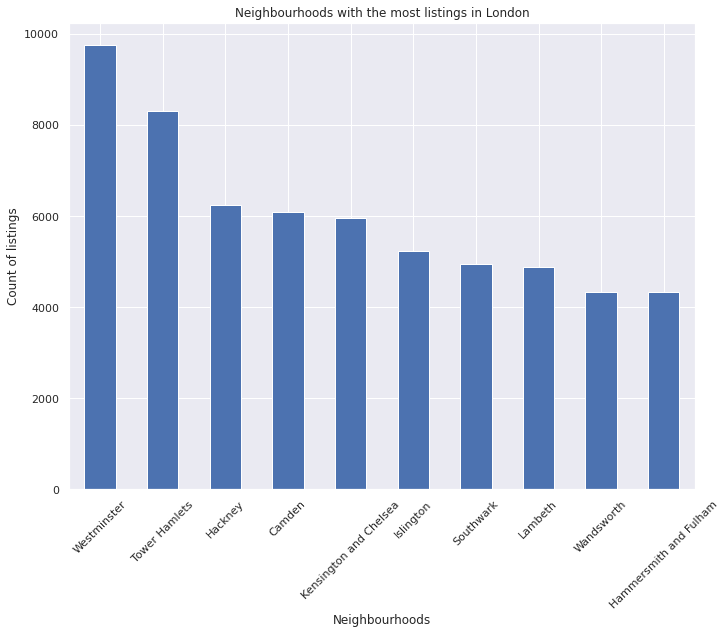

In [194]:
top_nbhoods= airbnb['neighbourhood_cleansed'].value_counts().head(10)

sns.set(rc={'figure.figsize':(10,8)})

viz_bar = top_nbhoods.plot(kind='bar')
viz_bar.set_title('Neighbourhoods with the most listings in London')
viz_bar.set_xlabel('Neighbourhoods')
viz_bar.set_ylabel('Count of listings')
viz_bar.set_xticklabels(viz_bar.get_xticklabels(), rotation=45)

In [65]:
coord = airbnb.loc[:,['longitude','latitude']]
coord.describe()

,longitude,latitude
count,85918.000000,85918.000000
mean,-0.127892,51.509576
std,0.092198,0.046265
min,-0.495820,51.294790
25%,-0.188020,51.485450
50%,-0.125660,51.514040
75%,-0.070000,51.537330
max,0.296570,51.681690


In [192]:
plt.figure(figsize=(18,12))
plt.style.use('fivethirtyeight')
BBox = (-0.4958, 0.2966, 51.2948, 51.6817)
ldn_map = json('neighbourhoods.geojson')
plt.imshow(ldn_map,zorder=0,extent=BBox)
ax = plt.gca()
groups = airbnb.groupby('neighbourhood_cleansed')
for name,group in groups :
    plt.scatter(group['longitude'],group['latitude'],label=name,alpha=0.5, edgecolors='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

TypeError: 'module' object is not callable

<Figure size 1296x864 with 0 Axes>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


<Figure size 2160x1800 with 0 Axes>

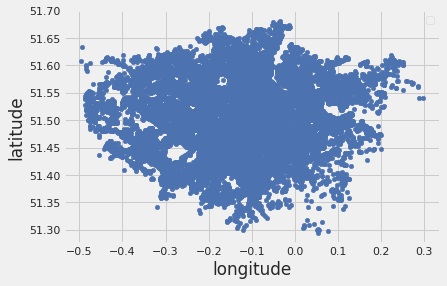

In [191]:
plt.figure(figsize=(30,25))
#plt.title("Map of Price Distribution")
ax=airbnb.plot(kind='scatter', x='longitude',y='latitude')
ax.legend()
plt.ioff()
plt.show()

---

## Part 2 - Executive Briefing

---

### 1 Executive Summary

This report provides an analysis of Airbnb activity in London based on data sourced from the Inside Airbnb website for the month of August 2019 – the last summer month prior to the COVID-19 pandemic. Through exploratory data analysis, we define what a ‘ghost hotel’ is and then set out to answer four main questions:
1. How many Airbnb listings in London are not the primary residence of the host?
2. How many Airbnb listings in London can be attributed to hosts with multiple listings?
3. How many Airbnb listings in London are operated by management companies?
4. Is the problem of ‘ghost hotels’ concentrated in certain areas of London or spread throughout?

#### Key Findings

#### Recommendations

---

### 2 Background

#### Airbnb

#### 'Ghost Hotels'

#### Inside Airbnb

---

### 3 Analysis

#### How many Airbnb listings in London are not the primary residence of the host?

#### How many Airbnb listings in London can be attributed to hosts with multiple listings? 

#### How many Airbnb listings in London are operated by management companies? 

#### Is the problem of 'ghost hotels' concentrated in certain areas of London or spread throughout?

---

### 4 Conclusion

---

### 5 References